# 1.  IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from termcolor import colored
from tqdm import tqdm


from scipy.sparse import csr_matrix
from implicit import als


from metrics import precision_at_k, recall_at_k, calc_recall, calc_precision, rerank_long, user_pred, user_pred_1
from utils import prefilter_items
from recommenders import MainRecommender

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler

# 2. DOWNLOAD DATA

In [496]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# 3. IMPORTANT VARIABLE

In [497]:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3
_n_popular = 50000
TOPK_PRECISION = 5
N_PREDICT = 200
ACTUAL_COL = 'actual'
CLEAN_ = False
# common_users find in part 7
LEAVE_CAT = True  # see part 14 and 15
STANDART = False

# 4. COLUMNS 

In [498]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
# What user really bought 
ACTUAL_COL = 'actual'

In [499]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# 5. TRAIN - VALIDATION SPLIT

In [500]:
# FIND VAL_MATCHER_WEEKS & VAL_RANKER_WEEKS in Part 3
train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]
val_matcher= data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

train_ranker = val_matcher.copy() 
val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

print('VAL_MATCHER_WEEKS =', colored(VAL_MATCHER_WEEKS, 'red'), ',VAL_RANKER_WEEKS =', colored(VAL_RANKER_WEEKS, 'red'))
print('Total ',colored(data.week_no.max(), 'red'), 'weeks')
print('train_matcher has',colored(train_matcher.week_no.max(), 'red'), 'weeks')
print('val_matcher has',colored(val_matcher.week_no.max() - train_matcher.week_no.max() , 'red'), 'weeks')
print('train_ranker has',colored(train_ranker.week_no.max() - train_matcher.week_no.max(), 'red'), 'weeks')
print('val_ranker has',colored(val_ranker.week_no.max() - train_ranker.week_no.max(), 'red'), 'weeks')

VAL_MATCHER_WEEKS = 6 ,VAL_RANKER_WEEKS = 3
Total  95 weeks
train_matcher has 85 weeks
val_matcher has 6 weeks
train_ranker has 6 weeks
val_ranker has 4 weeks


# 6. REDUCE ITEMS 

In [501]:
n_items_before = train_matcher['item_id'].nunique()

# FIND _n_popular in part 3
train_matcher = prefilter_items(train_matcher, item_features=item_features, take_n_popular=_n_popular)

n_items_after = train_matcher['item_id'].nunique()

print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/Users/kensei/Downloads/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 50001


# 7. "SOLVE" COLD START PROBLEM

In [502]:
common_users = train_matcher.user_id.values

val_matcher = val_matcher[val_matcher.user_id.isin(common_users)]
train_ranker = train_ranker[train_ranker.user_id.isin(common_users)]
val_ranker = val_ranker[val_ranker.user_id.isin(common_users)]

#P.S. We don't think about how solve cold start problem in this project

# 8. FID UP RECCOMENDER

In [503]:
recommender = MainRecommender(train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

# 9. CREATE DF WITH ITEM WAS BOUTH BY USER FOR VALIDATION DATA

In [504]:
# FIND ACTUAL_COL & USER_COL in part 4
print('Items were bought by user in last',colored(val_matcher.week_no.max() - train_matcher.week_no.max() , 'red'), 'weeks')
result_val_matcher = val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_val_matcher.columns=[USER_COL, ACTUAL_COL]
result_val_matcher.head(2)

Items were bought by user in last 6 weeks


,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [505]:
# mean len of shopping cart for validation data
print('Validation Data User activity')
print('User buy', colored(round(np.array([len(i) for i in result_val_matcher.actual]).mean()), 'red'),'items per',colored(val_matcher.week_no.max() - train_matcher.week_no.max() , 'red'), 'weeks.')
print('User buy', colored(round(np.array([len(i) for i in result_val_matcher.actual]).mean()/6), 'red'),'items per week.')

Validation Data User activity
User buy 66 items per 6 weeks.
User buy 11 items per week.


# 10. RECCOMEND

In [506]:
# # FIND N_PREDICT in part 3
result_val_matcher['rec_by_als'] = result_val_matcher[USER_COL].apply(lambda user: recommender.get_als_recommendations(user, N=N_PREDICT))

In [507]:
result_val_matcher['own_rec'] = result_val_matcher[USER_COL].apply(lambda user : recommender.get_own_recommendations(user, N=N_PREDICT))

In [508]:
print('RECALL OF Recommend')
for i in sorted(calc_recall(result_val_matcher, N_PREDICT), key=lambda x: x[1],reverse=True):
    print(i[0], i[1])

RECALL OF Recommend
own_rec 0.07596768223754194
rec_by_als 0.06557339798113053


# 11. GET USER - RECCOMENDED ITEM DF

In [509]:
match_items = pd.DataFrame(train_ranker[USER_COL].unique())
match_items.columns = [USER_COL]
print('This 6 weeks we have',match_items[USER_COL].nunique(), 'active users.')

This 6 weeks we have 2151 active users.


In [510]:
match_items['rec_items'] = match_items[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [511]:
df_items = match_items.apply(lambda x: pd.Series(x['rec_items']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
print('6 week at total we would recommend users', colored(len(df_items), 'red'), 'items.')

6 week at total we would recommend users 430200 items.


In [512]:
match_items = match_items.drop('rec_items', axis=1).join(df_items)
match_items.head(3)

,user_id,item_id
0,2070,1088026
0,2070,6442443
0,2070,9245184


# 12. INCREASE FEATURE FOR  USER - RECCOMENDED ITEM DF

## 12.1 Target

In [513]:
ranker_train = train_ranker[[USER_COL, ITEM_COL]].copy() # find train_ranker in 5 part
ranker_train['target'] = 1  

ranker_train = match_items.merge(ranker_train, on=[USER_COL, ITEM_COL], how='left')

ranker_train['target'].fillna(0, inplace= True)
print(colored(f"{ranker_train['target'].mean() * 100 :.2f}", 'red'), '% of Items have positive target.')

2.42 % of Items have positive target.


## 12.2 User And Item Features

In [514]:
ranker_train = ranker_train.merge(item_features, on='item_id', how='left')
ranker_train = ranker_train.merge(user_features, on='user_id', how='left')

## 12.3 Drop some 0 target

In [515]:
 # FIND CLEAN_ in part 3
if CLEAN_:
    ranker_train_negative = ranker_train[ranker_train['target'] == 0]
    index_drop = [i for i in range(0, len(ranker_train_negative), 2)]
    
    ranker_train_negative = ranker_train_negative.drop(ranker_train_negative.index[index_drop])
    ranker_train_positive = ranker_train[ranker_train['target'] == 1]
    ranker_train = pd.concat([ranker_train_negative, ranker_train_positive])

## 12.4 Item quantity sold

In [516]:
# Agregate data
# WE USE HERE ALL DATA, BUT ALSO WE CAN YOU ONLY TRAIN DATA
item_n_sold = data.groupby('item_id')['quantity'].sum().reset_index()
item_n_sold.columns=['item_id', 'item_sold']
# Convert to list
item_l = item_n_sold.item_id.tolist()
i_income = item_n_sold.item_sold.tolist()
# Create a dict for high perfomance in future
sale_dict = {}
for i in range(len(item_l)):
    sale_dict[item_l[i]] = i_income[i]

In [517]:
tqdm.pandas()
ranker_train['i_quantity_sold'] = ranker_train['item_id'].progress_apply(lambda x: sale_dict[x])

100%|██████████| 432878/432878 [00:00<00:00, 1029705.43it/s]


In [518]:
ranker_train['i_quantity_sold'].describe()

count    432878.000000
mean        725.707784
std        1876.437407
min           1.000000
25%          20.000000
50%          59.000000
75%         837.000000
max       28384.000000
Name: i_quantity_sold, dtype: float64

Text(0.5, 1.0, 'Mean sold quantity of different target items')

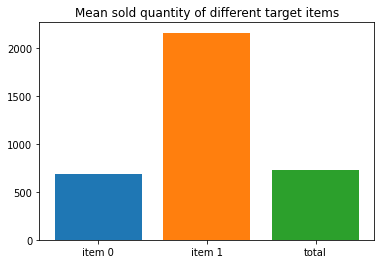

In [519]:
plt.bar(height=ranker_train[ranker_train.target == 0].i_quantity_sold.mean(), x='item 0') # user didn't buy
plt.bar(height=ranker_train[ranker_train.target == 1].i_quantity_sold.mean(), x='item 1') # user bought it
plt.bar(height=ranker_train.i_quantity_sold.mean(), x='total') # mean for all kind
plt.title('Mean sold quantity of different target items')

## 12.5 User total bought value

In [520]:
user_buy = data.groupby('user_id')['sales_value'].sum().reset_index()
user_buy.columns=['user_id', 'total_buy']
item_l = user_buy.user_id.tolist()
i_income = user_buy.total_buy.tolist()
sale_dict = {}
for i in range(len(item_l)):
    sale_dict[item_l[i]] = i_income[i]

In [521]:
ranker_train['user_total_buy'] = ranker_train.user_id.progress_apply(lambda x: sale_dict[x])

100%|██████████| 432878/432878 [00:00<00:00, 1045909.75it/s]


In [522]:
ranker_train['user_total_buy'].describe()

count    432878.000000
mean       3323.332364
std        3211.872868
min          47.900000
25%        1132.170000
50%        2304.580000
75%        4515.800000
max       34869.040000
Name: user_total_buy, dtype: float64

## 12.6 Item total sold value

In [523]:
item_sale = data.groupby('item_id')['sales_value'].sum().reset_index()
item_sale.columns=['item_id', 'total_income']

item_l = item_sale.item_id.tolist()
i_income = item_sale.total_income.tolist()

sale_dict = {}
for i in range(len(item_l)):
    sale_dict[item_l[i]] = i_income[i]

In [524]:
ranker_train['item_total_sold'] = ranker_train.item_id.progress_apply(lambda x: sale_dict[x])

100%|██████████| 432878/432878 [00:00<00:00, 1006608.03it/s]


## 12.7  Users buy per week

In [525]:
ranker_train['user_buy_per_week'] = ranker_train['user_total_buy'] / 95

## 12.8 User buy this item value per week

In [526]:
ranker_train['u_buy_item_weekly'] = 0
ranker_train.loc[ranker_train['target'] == 1, 'u_buy_item_weekly'] = ranker_train['item_total_sold'] / 95

## 12.9 Item in 100, 500, 1000 popular

In [527]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
sort_popular = popularity.sort_values('sales_value')
sort_popular = sort_popular.item_id.tolist()

In [528]:
ranker_train['top_100'] = ranker_train.item_id.apply(lambda x: 1 if x in sort_popular[-100:] else 0)
ranker_train['top_500'] = ranker_train.item_id.apply(lambda x: 1 if x in sort_popular[-500:] else 0)
ranker_train['top_1000'] = ranker_train.item_id.apply(lambda x: 1 if x in sort_popular[-1000:] else 0)

## 12.10 CONVERT CATEGORY

In [529]:
ranker_train['brand'] = ranker_train['brand'].replace(['National', 'Private'],[0, 1])

In [530]:
ranker_train.age_desc = ranker_train.age_desc.fillna(ranker_train.age_desc.mode()[0])

ages_ = {}
uniq_ages_ = ranker_train.age_desc.unique()
for i in range(len(uniq_ages_)):
    ages_[uniq_ages_[i]] = i

ranker_train['age_desc'] = [ages_[x] for x in ranker_train['age_desc']]

In [531]:
ranker_train.kid_category_desc = ranker_train.kid_category_desc.fillna(ranker_train.kid_category_desc.mode()[0])

kind_cat_ = {}
uniq_kind_ = ranker_train.kid_category_desc.unique()
for i in range(len(uniq_kind_)):
    kind_cat_[uniq_kind_[i]] = i

ranker_train['kid_category_desc'] = [kind_cat_[x] for x in ranker_train['kid_category_desc']]

## 12.11 User buy popular item or not

In [532]:
ranker_train['user_buy_popular'] = 0
ranker_train.loc[(ranker_train['target'] == 1) & (ranker_train['top_100'] == 1), 'user_buy_popular'] = 1

In [533]:
ranker_train['user_buy_not_popular'] = 0
ranker_train.loc[(ranker_train['target'] == 1) & (ranker_train['top_100'] != 1) & (ranker_train['top_500'] != 1) & (ranker_train['top_1000'] != 1), 'user_buy_not_popular'] = 1

## 12.12 Item bought by coupon

In [534]:
item_sale = data.groupby('item_id')['coupon_disc'].sum().reset_index()
item_sale.columns=['item_id', 'i_coupon_disc']

item_l = item_sale.item_id.tolist()
i_income = item_sale.i_coupon_disc.tolist()

sale_dict = {}
for i in range(len(item_l)):
    sale_dict[item_l[i]] = i_income[i]

In [535]:
ranker_train['i_coupon_disc'] = ranker_train.item_id.progress_apply(lambda x: sale_dict[x])

100%|██████████| 432878/432878 [00:00<00:00, 1007968.23it/s]


## 12.13 User used coupon

In [536]:
item_sale = data.groupby('user_id')['coupon_disc'].sum().reset_index()
item_sale.columns=['user_id', 'u_coupon_disc']

item_l = item_sale.user_id.tolist()
i_income = item_sale.u_coupon_disc.tolist()

sale_dict = {}
for i in range(len(item_l)):
    sale_dict[item_l[i]] = i_income[i]

In [537]:
ranker_train['u_coupon_disc'] = ranker_train.user_id.progress_apply(lambda x: sale_dict[x])

100%|██████████| 432878/432878 [00:00<00:00, 1053869.96it/s]


## 12.14 Scaler

In [538]:
if STANDART: 
    scaler = StandardScaler()
    ranker_train[['user_id', 'item_id', 'target', 'brand','manufacturer',
       'age_desc', 'kid_category_desc',
       'i_quantity_sold', 'user_total_buy', 'item_total_sold',
       'user_buy_per_week', 'u_buy_item_weekly', 'top_100', 'top_500',
       'top_1000', 'user_buy_popular', 'user_buy_not_popular', 'i_coupon_disc',
       'u_coupon_disc']] = scaler.fit_transform(ranker_train[['user_id', 'item_id', 'target', 'brand', 'manufacturer',
       'age_desc', 'kid_category_desc',
       'i_quantity_sold', 'user_total_buy', 'item_total_sold',
       'user_buy_per_week', 'u_buy_item_weekly', 'top_100', 'top_500',
       'top_1000', 'user_buy_popular', 'user_buy_not_popular', 'i_coupon_disc',
       'u_coupon_disc']])

## 12.15 DEL

In [539]:
# ranker_train = ranker_train.drop([ 'manufacturer', 'age_desc', 'kid_category_desc'], axis=1)

In [540]:
ranker_train = ranker_train.drop(['u_coupon_disc', 'brand', 'i_coupon_disc',], axis=1)

# 13. Data for arrange

In [541]:
X_train = ranker_train.drop('target', axis=1)
y_train = ranker_train[['target']]

# 14. Prepear Data

In [542]:
X_train = X_train.drop(['department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',], axis=1)

In [543]:
X_train.income_desc = X_train.income_desc.fillna(X_train.income_desc.mode()[0])
X_train.marital_status_code = X_train.marital_status_code.fillna(X_train.marital_status_code.mode()[0])
X_train.homeowner_desc = X_train.homeowner_desc.fillna(X_train.homeowner_desc.mode()[0])
X_train.hh_comp_desc = X_train.hh_comp_desc.fillna(X_train.hh_comp_desc.mode()[0])
X_train.household_size_desc = X_train.household_size_desc.fillna(X_train.household_size_desc.mode()[0])

In [544]:
X_train.dtypes

user_id                  int64
item_id                  int64
manufacturer             int64
age_desc                 int64
marital_status_code     object
income_desc             object
homeowner_desc          object
hh_comp_desc            object
household_size_desc     object
kid_category_desc        int64
i_quantity_sold          int64
user_total_buy         float64
item_total_sold        float64
user_buy_per_week      float64
u_buy_item_weekly      float64
top_100                  int64
top_500                  int64
user_buy_popular         int64
dtype: object

In [545]:
X_train.columns[5:10]

Index(['income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
       'kid_category_desc'],
      dtype='object')

In [546]:
if LEAVE_CAT: # for LEAVE_CAT see part 3
    cat_feats = X_train.columns[4:9].tolist()
else:
    X_train = X_train.drop(cat_feats, axis=1)
    

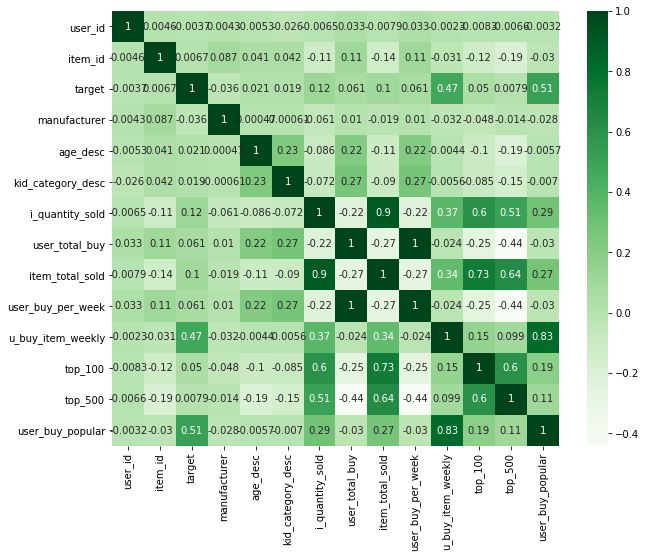

In [547]:
sns.heatmap(ranker_train.corr(), annot=True, cmap='Greens')
fig=plt.gcf()
fig.set_size_inches(10,8)

# 15. Modeling

In [548]:
if LEAVE_CAT: # for LEAVE_CAT see part 3
    model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           cat_features=cat_feats
                          )
else:
      model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                          )


In [549]:
model.fit(X_train, y_train)

0:	learn: 0.3529667	total: 205ms	remaining: 3m 24s
1:	learn: 0.1709506	total: 428ms	remaining: 3m 33s
2:	learn: 0.0927884	total: 564ms	remaining: 3m 7s
3:	learn: 0.0465221	total: 769ms	remaining: 3m 11s
4:	learn: 0.0243539	total: 963ms	remaining: 3m 11s
5:	learn: 0.0129732	total: 1.16s	remaining: 3m 11s
6:	learn: 0.0074246	total: 1.4s	remaining: 3m 18s
7:	learn: 0.0045469	total: 1.59s	remaining: 3m 17s
8:	learn: 0.0029206	total: 1.81s	remaining: 3m 19s
9:	learn: 0.0019254	total: 2s	remaining: 3m 18s
10:	learn: 0.0013392	total: 2.22s	remaining: 3m 20s
11:	learn: 0.0009674	total: 2.44s	remaining: 3m 20s
12:	learn: 0.0007251	total: 2.65s	remaining: 3m 21s
13:	learn: 0.0005587	total: 2.85s	remaining: 3m 20s
14:	learn: 0.0004548	total: 3.04s	remaining: 3m 19s
15:	learn: 0.0003696	total: 3.26s	remaining: 3m 20s
16:	learn: 0.0003085	total: 3.45s	remaining: 3m 19s
17:	learn: 0.0002554	total: 3.62s	remaining: 3m 17s
18:	learn: 0.0002225	total: 3.84s	remaining: 3m 18s
19:	learn: 0.0001934	total:

159:	learn: 0.0000421	total: 29.9s	remaining: 2m 37s
160:	learn: 0.0000421	total: 30.1s	remaining: 2m 36s
161:	learn: 0.0000421	total: 30.3s	remaining: 2m 36s
162:	learn: 0.0000421	total: 30.4s	remaining: 2m 36s
163:	learn: 0.0000421	total: 30.6s	remaining: 2m 36s
164:	learn: 0.0000421	total: 30.7s	remaining: 2m 35s
165:	learn: 0.0000421	total: 30.9s	remaining: 2m 35s
166:	learn: 0.0000421	total: 31s	remaining: 2m 34s
167:	learn: 0.0000421	total: 31.2s	remaining: 2m 34s
168:	learn: 0.0000421	total: 31.4s	remaining: 2m 34s
169:	learn: 0.0000421	total: 31.6s	remaining: 2m 34s
170:	learn: 0.0000421	total: 31.7s	remaining: 2m 33s
171:	learn: 0.0000421	total: 31.9s	remaining: 2m 33s
172:	learn: 0.0000421	total: 32s	remaining: 2m 33s
173:	learn: 0.0000421	total: 32.2s	remaining: 2m 32s
174:	learn: 0.0000421	total: 32.4s	remaining: 2m 32s
175:	learn: 0.0000421	total: 32.6s	remaining: 2m 32s
176:	learn: 0.0000421	total: 32.7s	remaining: 2m 32s
177:	learn: 0.0000421	total: 32.9s	remaining: 2m 3

317:	learn: 0.0000419	total: 54.7s	remaining: 1m 57s
318:	learn: 0.0000419	total: 54.8s	remaining: 1m 57s
319:	learn: 0.0000419	total: 55s	remaining: 1m 56s
320:	learn: 0.0000419	total: 55.2s	remaining: 1m 56s
321:	learn: 0.0000419	total: 55.3s	remaining: 1m 56s
322:	learn: 0.0000419	total: 55.5s	remaining: 1m 56s
323:	learn: 0.0000419	total: 55.6s	remaining: 1m 56s
324:	learn: 0.0000419	total: 55.8s	remaining: 1m 55s
325:	learn: 0.0000419	total: 56s	remaining: 1m 55s
326:	learn: 0.0000419	total: 56.1s	remaining: 1m 55s
327:	learn: 0.0000419	total: 56.3s	remaining: 1m 55s
328:	learn: 0.0000419	total: 56.5s	remaining: 1m 55s
329:	learn: 0.0000419	total: 56.6s	remaining: 1m 54s
330:	learn: 0.0000419	total: 56.7s	remaining: 1m 54s
331:	learn: 0.0000419	total: 56.9s	remaining: 1m 54s
332:	learn: 0.0000419	total: 57.1s	remaining: 1m 54s
333:	learn: 0.0000419	total: 57.2s	remaining: 1m 54s
334:	learn: 0.0000419	total: 57.4s	remaining: 1m 53s
335:	learn: 0.0000419	total: 57.6s	remaining: 1m 5

471:	learn: 0.0000417	total: 1m 18s	remaining: 1m 27s
472:	learn: 0.0000417	total: 1m 18s	remaining: 1m 27s
473:	learn: 0.0000417	total: 1m 18s	remaining: 1m 26s
474:	learn: 0.0000417	total: 1m 18s	remaining: 1m 26s
475:	learn: 0.0000417	total: 1m 18s	remaining: 1m 26s
476:	learn: 0.0000417	total: 1m 18s	remaining: 1m 26s
477:	learn: 0.0000417	total: 1m 18s	remaining: 1m 25s
478:	learn: 0.0000417	total: 1m 18s	remaining: 1m 25s
479:	learn: 0.0000417	total: 1m 18s	remaining: 1m 25s
480:	learn: 0.0000417	total: 1m 18s	remaining: 1m 25s
481:	learn: 0.0000417	total: 1m 19s	remaining: 1m 24s
482:	learn: 0.0000417	total: 1m 19s	remaining: 1m 24s
483:	learn: 0.0000417	total: 1m 19s	remaining: 1m 24s
484:	learn: 0.0000417	total: 1m 19s	remaining: 1m 24s
485:	learn: 0.0000417	total: 1m 19s	remaining: 1m 23s
486:	learn: 0.0000417	total: 1m 19s	remaining: 1m 23s
487:	learn: 0.0000417	total: 1m 19s	remaining: 1m 23s
488:	learn: 0.0000417	total: 1m 19s	remaining: 1m 23s
489:	learn: 0.0000417	total:

627:	learn: 0.0000415	total: 1m 33s	remaining: 55.4s
628:	learn: 0.0000415	total: 1m 33s	remaining: 55.3s
629:	learn: 0.0000415	total: 1m 33s	remaining: 55.1s
630:	learn: 0.0000415	total: 1m 33s	remaining: 54.9s
631:	learn: 0.0000415	total: 1m 33s	remaining: 54.7s
632:	learn: 0.0000415	total: 1m 34s	remaining: 54.5s
633:	learn: 0.0000415	total: 1m 34s	remaining: 54.4s
634:	learn: 0.0000415	total: 1m 34s	remaining: 54.2s
635:	learn: 0.0000415	total: 1m 34s	remaining: 54s
636:	learn: 0.0000415	total: 1m 34s	remaining: 53.8s
637:	learn: 0.0000415	total: 1m 34s	remaining: 53.7s
638:	learn: 0.0000415	total: 1m 34s	remaining: 53.5s
639:	learn: 0.0000415	total: 1m 34s	remaining: 53.3s
640:	learn: 0.0000415	total: 1m 34s	remaining: 53.1s
641:	learn: 0.0000415	total: 1m 34s	remaining: 53s
642:	learn: 0.0000415	total: 1m 35s	remaining: 52.8s
643:	learn: 0.0000415	total: 1m 35s	remaining: 52.6s
644:	learn: 0.0000415	total: 1m 35s	remaining: 52.4s
645:	learn: 0.0000415	total: 1m 35s	remaining: 52.

784:	learn: 0.0000414	total: 1m 50s	remaining: 30.2s
785:	learn: 0.0000414	total: 1m 50s	remaining: 30.1s
786:	learn: 0.0000414	total: 1m 50s	remaining: 29.9s
787:	learn: 0.0000414	total: 1m 50s	remaining: 29.8s
788:	learn: 0.0000414	total: 1m 50s	remaining: 29.6s
789:	learn: 0.0000414	total: 1m 50s	remaining: 29.5s
790:	learn: 0.0000414	total: 1m 50s	remaining: 29.3s
791:	learn: 0.0000414	total: 1m 51s	remaining: 29.2s
792:	learn: 0.0000414	total: 1m 51s	remaining: 29s
793:	learn: 0.0000414	total: 1m 51s	remaining: 28.9s
794:	learn: 0.0000414	total: 1m 51s	remaining: 28.7s
795:	learn: 0.0000414	total: 1m 51s	remaining: 28.6s
796:	learn: 0.0000414	total: 1m 51s	remaining: 28.4s
797:	learn: 0.0000414	total: 1m 51s	remaining: 28.3s
798:	learn: 0.0000414	total: 1m 51s	remaining: 28.1s
799:	learn: 0.0000414	total: 1m 51s	remaining: 28s
800:	learn: 0.0000414	total: 1m 52s	remaining: 27.8s
801:	learn: 0.0000414	total: 1m 52s	remaining: 27.7s
802:	learn: 0.0000414	total: 1m 52s	remaining: 27.

941:	learn: 0.0000414	total: 2m 6s	remaining: 7.8s
942:	learn: 0.0000414	total: 2m 6s	remaining: 7.67s
943:	learn: 0.0000414	total: 2m 6s	remaining: 7.53s
944:	learn: 0.0000414	total: 2m 7s	remaining: 7.39s
945:	learn: 0.0000414	total: 2m 7s	remaining: 7.26s
946:	learn: 0.0000414	total: 2m 7s	remaining: 7.12s
947:	learn: 0.0000414	total: 2m 7s	remaining: 6.99s
948:	learn: 0.0000414	total: 2m 7s	remaining: 6.85s
949:	learn: 0.0000414	total: 2m 7s	remaining: 6.71s
950:	learn: 0.0000414	total: 2m 7s	remaining: 6.58s
951:	learn: 0.0000414	total: 2m 7s	remaining: 6.44s
952:	learn: 0.0000414	total: 2m 7s	remaining: 6.31s
953:	learn: 0.0000413	total: 2m 8s	remaining: 6.17s
954:	learn: 0.0000413	total: 2m 8s	remaining: 6.04s
955:	learn: 0.0000413	total: 2m 8s	remaining: 5.9s
956:	learn: 0.0000413	total: 2m 8s	remaining: 5.77s
957:	learn: 0.0000413	total: 2m 8s	remaining: 5.64s
958:	learn: 0.0000413	total: 2m 8s	remaining: 5.5s
959:	learn: 0.0000413	total: 2m 8s	remaining: 5.37s
960:	learn: 0.0

# 16. Predict

In [550]:
train_preds = model.predict_proba(X_train)

In [551]:
ranker_train_predict = ranker_train.copy()

In [552]:
ranker_train_predict['proba_item_purchase'] = train_preds[:,1]

In [553]:
ranker_train_predict.head(3)

,user_id,item_id,target,manufacturer,department,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,kid_category_desc,i_quantity_sold,user_total_buy,item_total_sold,user_buy_per_week,u_buy_item_weekly,top_100,top_500,user_buy_popular,proba_item_purchase
0,2070,1088026,0.0,4951,DRUG GM,SINUS AND ALLERGY,SINUS AND ALLERGY,,0,U,...,0,17,6981.86,83.79,73.493263,0.0,0,0,0,0.000037
1,2070,6442443,0.0,378,GROCERY,BAG SNACKS,POTATO CHIPS,10 OZ,0,U,...,0,49,6981.86,128.87,73.493263,0.0,0,0,0,0.000005
2,2070,9245184,0.0,1025,DELI,SANDWICHES,SANDWICHES - (COLD),,0,U,...,0,2,6981.86,11.98,73.493263,0.0,0,0,0,0.000030


# 17. Train Ranking

In [554]:
result_val_ranker = val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_val_ranker.columns=[USER_COL, ACTUAL_COL]
result_val_ranker.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [555]:
result_val_ranker['own_rec'] = result_val_ranker[USER_COL].progress_apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

100%|██████████| 2040/2040 [00:04<00:00, 430.96it/s]


In [556]:
result_val_ranker['reranked_own_rec'] = result_val_ranker[USER_COL].progress_apply(lambda user_id: rerank_long(user_id, ranker_train_predict))

100%|██████████| 2040/2040 [00:01<00:00, 1469.81it/s]


# 18. Train Validation

In [557]:
print(*sorted(calc_precision(result_val_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

/Users/kensei/Downloads/webinar_6/metrics.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('reranked_own_rec', 0.13671018276762403)
('own_rec', 0.058823529411764705)


# 19. Test Reccomend and Ranking

In [558]:
test_1 = pd.read_csv("retail_test1.csv")
df_transactions = pd.read_csv('retail_train.csv')

In [559]:
result_test = test_1.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test = result_test[result_test['user_id'].isin(common_users)]
result_test.head(3)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."
2,3,"[827683, 908531, 989069, 1071377, 1080155, 109..."


In [560]:
result_test['als_rec'] = result_test[USER_COL].progress_apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

100%|██████████| 1883/1883 [00:05<00:00, 344.00it/s]


In [561]:
result_test['own_rec'] = result_test[USER_COL].progress_apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

100%|██████████| 1883/1883 [00:03<00:00, 496.85it/s]


In [562]:
result_test['reranked_own_rec'] = result_test[USER_COL].progress_apply(lambda user_id: rerank_long(user_id, ranker_train_predict=ranker_train_predict))

100%|██████████| 1883/1883 [00:01<00:00, 1466.14it/s]


# 20. TEST RANKING SCORE

In [563]:
for i in sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True,):
    print(i[0],':',i[1])

reranked_own_rec : 0.10608108108108108
als_rec : 0.09283058948486457
own_rec : 0.04907063197026022


/Users/kensei/Downloads/webinar_6/metrics.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


In [564]:
TOPK_PRECISION = 10
for i in sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True,):
    print(i[0],':',i[1])

reranked_own_rec : 0.10608108108108108
als_rec : 0.06760488582049921
own_rec : 0.03271375464684015


In [565]:
TOPK_PRECISION = 20
for i in sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True,):
    print(i[0],':',i[1])

reranked_own_rec : 0.10608108108108108
als_rec : 0.04723844928305894
own_rec : 0.022198619224641527


# 21. Safe result

In [566]:
params = model._get_params()
params['feautures'] = list(X_train.columns)
params['feautures_len'] = len(list(X_train.columns))
params['N_PREDICT'] = N_PREDICT
params['index_drop'] = CLEAN_
params['n_popular'] = _n_popular
params['valideted_train'] = True # it means we did split for train and val parts before test
params['reranked_own_rec'] = sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True)[0][1]

In [2]:
my_progress_df = pd.read_csv('results.csv')#
# my_progress_df = my_progress_df.append(params, ignore_index=True)

In [568]:
# my_progress_df = my_progress_df[['depth', 'iterations', 'l2_leaf_reg', 'learning_rate', 'loss_function',
#        'feautures', 'feautures_len', 'N_PREDICT', 'index_drop', 'n_popular',
#        'valideted_train',  'cat_features','reranked_own_rec',]]

In [6]:
my_progress_df.sort_values('reranked_own_rec', ascending=False).head(10)

,depth,iterations,l2_leaf_reg,learning_rate,loss_function,feautures,feautures_len,N_PREDICT,index_drop,n_popular,valideted_train,cat_features,reranked_own_rec
109,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,580,0,11000,True,"['marital_status_code', 'income_desc', 'homeow...",0.164302
105,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,540,0,11000,True,"['marital_status_code', 'income_desc', 'homeow...",0.159685
121,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,490,0,12000,True,"['marital_status_code', 'income_desc', 'homeow...",0.159459
131,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,590,0,12000,True,"['marital_status_code', 'income_desc', 'homeow...",0.158671
193,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,580,0,15000,True,"['marital_status_code', 'income_desc', 'homeow...",0.156757
214,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,580,0,16000,True,"['marital_status_code', 'income_desc', 'homeow...",0.156194
106,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,550,0,11000,True,"['marital_status_code', 'income_desc', 'homeow...",0.155293
97,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,460,0,11000,True,"['marital_status_code', 'income_desc', 'homeow...",0.154617
225,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,480,0,17000,True,"['marital_status_code', 'income_desc', 'homeow...",0.154279
140,10,1000,5,0.1,Logloss,"['user_id', 'item_id', 'manufacturer', 'age_de...",20,470,0,13000,True,"['marital_status_code', 'income_desc', 'homeow...",0.154054


In [570]:
my_progress_df.to_csv('results.csv', index=False)